# Case 1 - Elastic-Net Regression

1. **Importing Libraries**

2. **Loading Data**

3. **Elastic Net Regression**
- Elastic Net Regression because we have many variables that we do not know. Elastic Net combines the strengths of Lasso regression (L1) and Ridge regression. Lasso regression can shrink parameters to 0 which is useful for large dataset where some parameters might be useless. Ridge regression tends to perform better when parameters are not useless. Therefore, elastic net is useful in this case as we do not know our parameters.
- Find optimal model parameters, lamdba_1 and lambda_2 by using 5-fold cross validation.
- Get root mean squared error (RMSE) by applying the model with the optimal model parameters on the test data.

## 1. Importing Libraries

In [1]:
import numpy as np
import pandas as pd

%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns
sns.set() # Set searborn as default

from sklearn.linear_model import ElasticNetCV
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import KFold
from sklearn.preprocessing import StandardScaler
from sklearn.impute import KNNImputer, SimpleImputer

import warnings

# Set seed for reproducibility
import random
random.seed(42)

# 2. Elastic Net Regression

**Alpha**
- Definition: Alpha is the regularization strength parameter in Elastic Net.
- Role: It controls the overall strength of regularization applied to the model.
- Values:
    - For α=0: No regularization is applied, and Elastic Net becomes equivalent to Ordinary Least Squares (OLS) regression.
    - For α=1: Both L1 and L2 regularization are applied, combining the penalties of Lasso and Ridge.
    - For 0<α<1: Elastic Net applies a mixture of L1 and L2 regularization, allowing for a flexible combination of penalties.

**L1 Ratio (l1_ratio)**
- Definition: L1 ratio is the mixing parameter that determines the balance between L1 and L2 penalties.
- Role: It controls the proportion of the penalty assigned to the L1 norm relative to the L2 norm.
- Values:
    - For l1_ratio=0: Elastic Net applies only L2 regularization (equivalent to Ridge regression).
    - For l1_ratio=1: Elastic Net applies only L1 regularization (equivalent to Lasso regression).
    - For 0<l1_ratio<1: Elastic Net applies a combination of both L1 and L2 regularization, allowing for a mix of penalties.

In [2]:
X = np.loadtxt('../data/case1Data_X.csv', delimiter=',')
y = np.loadtxt('../data/case1Data_y.csv', delimiter=',')

# Setting a range of alphas and l1_ratios to test
alphas = np.logspace(-4, 1, 100) # Testing a range from very weak to strong regularization
l1_ratios = np.concatenate(([0], np.logspace(-10, 0, 100))) # Testing a range from L2 (0) to L1 (1) regularization

# Outer 5-fold cross-validation
outer_cv = KFold(n_splits=5, shuffle=True, random_state=42)
rmse_scores = []
alpha_scores = []
l1_ratio_scores = []

for train_idx, test_idx in outer_cv.split(X, y):
    X_train, X_test = X[train_idx], X[test_idx]
    y_train, y_test = y[train_idx], y[test_idx]

    #### Data Preprocessing ####

    # Convert the numpy arrays to pandas DataFrames
    X_train = pd.DataFrame(X_train)
    X_test = pd.DataFrame(X_test)

    # Using StandardScaler from scikit-learn to standardize the data
    scaler = StandardScaler()

    # Standardizing the numerical features (all columns exept the last five)
    X_train.iloc[:, :95] = scaler.fit_transform(X_train.iloc[:, :95])
    X_test.iloc[:, :95] = scaler.transform(X_test.iloc[:, :95])

    # class sklearn.impute.KNNImputer(*, missing_values=nan, n_neighbors=5, weights='uniform', metric='nan_euclidean', copy=True, add_indicator=False, keep_empty_features=False)
    continuous_imputer = KNNImputer(n_neighbors=5, missing_values=np.nan)

    # Fitting the imputer on the training data and transforming the training and test data
    X_train.iloc[:, :95] = pd.DataFrame(continuous_imputer.fit_transform(X_train.iloc[:, :95]))
    X_test.iloc[:, :95] = pd.DataFrame(continuous_imputer.transform(X_test.iloc[:, :95]))

    # Mode Imputation: Using SimpleImputer from scikit-learn to impute the missing values in the data (for categorical variables) with the most frequent value
    categorical_imputer = SimpleImputer(strategy='most_frequent')
    
    # Fitting the imputer on the training data and transforming the training and test data
    X_train.iloc[:, -5:] = categorical_imputer.fit_transform(X_train.iloc[:, -5:])
    X_test.iloc[:, -5:] = categorical_imputer.transform(X_test.iloc[:, -5:])
    
    # One-hot encoding the categorical variables using get_dummies from pandas library (for the last five columns)
    X_train = pd.get_dummies(X_train, columns=X_train.columns[-5:])
    X_test = pd.get_dummies(X_test, columns=X_test.columns[-5:])

    # Align the columns of the training and test data
    X_train, X_test = X_train.align(X_test, join='left', axis=1, fill_value=0)

    # Convert the pandas DataFrames back to numpy arrays
    X_train = np.asarray(X_train, dtype=np.float64)
    X_test = np.asarray(X_test, dtype=np.float64)

    # Inner loop for hyperparameter tuning (5-fold CV)
    with warnings.catch_warnings():  # Suppress convergence warnings
        warnings.simplefilter("ignore")
        model = ElasticNetCV(cv=5, l1_ratio=l1_ratios, alphas=alphas, fit_intercept=False, random_state=42).fit(X_train, y_train)

    #### Evaluation ####

    # Predicting the target values on the test set using the optimal model
    y_pred = model.predict(X_test)

    # Calculate the RMSE
    rmse = np.sqrt(mean_squared_error(y_test, y_pred))
    rmse_scores.append(rmse)

    # Save the optimal alpha
    alpha_scores.append(model.alpha_)

    # Save the optimal l1_ratio
    l1_ratio_scores.append(model.l1_ratio_)

    # Saving the optimal model
    if rmse == min(rmse_scores):
        best_model = model

    # Print the results of the inner loop
    print(f'Fold RMSE: {rmse:.4f}')
    print(f'Optimal alpha: {model.alpha_}')
    print(f'Optimal l1_ratio: {model.l1_ratio_}\n')

# Final performance
print(f'Average RMSE across outer folds: {np.mean(rmse_scores):.4f}')
print(f'Average alpha: {np.mean(alpha_scores)}')
print(f'Average l1_ratio: {np.mean(l1_ratio_scores)}')
# Standard deviation of the RMSE tells us how much the RMSE varies between the folds (i.e., how stable the model is)
print(f'Standard deviation of RMSE: {np.std(rmse_scores):.4f}')


Fold RMSE: 26.1366
Optimal alpha: 0.6135907273413169
Optimal l1_ratio: 1.0

Fold RMSE: 23.3240
Optimal alpha: 1.5556761439304723
Optimal l1_ratio: 1.0

Fold RMSE: 26.3223
Optimal alpha: 0.8697490026177834
Optimal l1_ratio: 1.0

Fold RMSE: 25.8996
Optimal alpha: 1.5556761439304723
Optimal l1_ratio: 1.0

Fold RMSE: 29.8694
Optimal alpha: 0.9770099572992247
Optimal l1_ratio: 1.0

Average RMSE across outer folds: 26.3104
Average alpha: 1.114340395023854
Average l1_ratio: 1.0
Standard deviation of RMSE: 2.0873


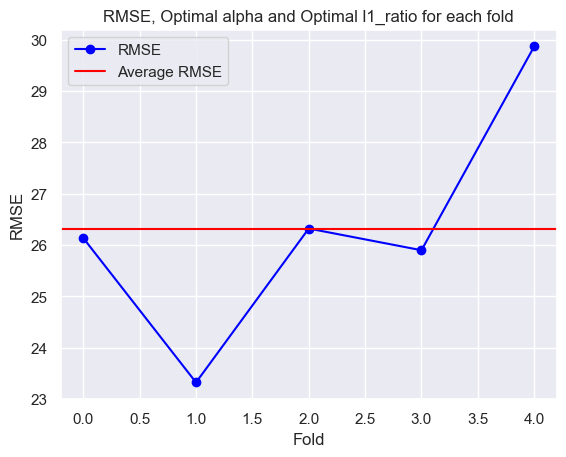

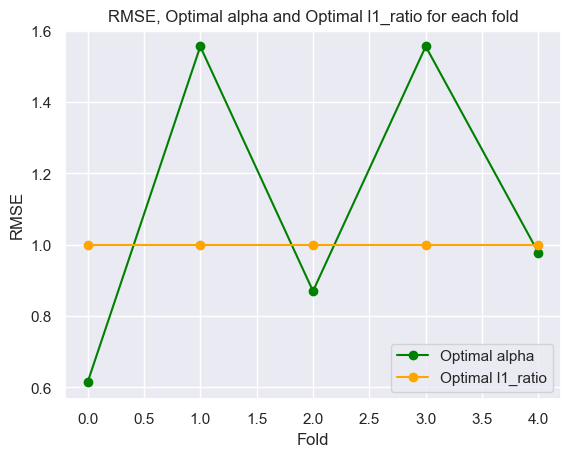

In [3]:
# Plotting the RMSE scores, optimal alpha and optimal l1_ratio for each fold
plt.close('all')
plt.figure()
plt.plot(rmse_scores, 'o-', label='RMSE', color='blue')
plt.axhline(np.mean(rmse_scores), label='Average RMSE', color='red')
plt.xlabel('Fold')
plt.ylabel('RMSE')
plt.title('RMSE, Optimal alpha and Optimal l1_ratio for each fold')
plt.legend()
plt.show()

plt.close('all')
plt.figure()
plt.plot(alpha_scores, 'o-', label='Optimal alpha', color='green')
plt.plot(l1_ratio_scores, 'o-', label='Optimal l1_ratio', color='orange')
plt.xlabel('Fold')
plt.ylabel('RMSE')
plt.title('RMSE, Optimal alpha and Optimal l1_ratio for each fold')
plt.legend()
plt.show()